# License detector pipeline visualization

In [831]:
import importlib

import matplotlib

from notebooks.utils import cd_git_root, show, show_contours

matplotlib.rcParams["savefig.pad_inches"] = 0

cd_git_root()

In [832]:
from datasets.load import load_platesmania

datasets = load_platesmania()
ds = datasets.train

paths = ds.paths
to_filter = {
    # 1: "hard",
    # 11: "hard",
    # 12: "hard",
}
paths = [filename for i, filename in enumerate(paths) if i not in to_filter]
path = paths[17]

print("path:", path)

path: datasets/03-platesmania/pl_GSL-60818_1.jpg


## Image loading

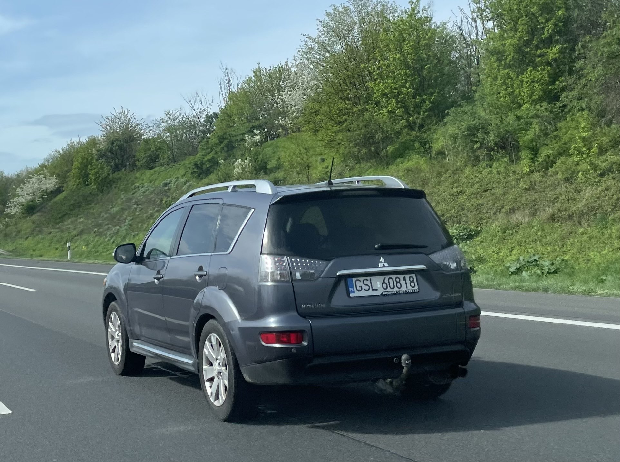

In [833]:
from twm_proj.implementation.image_reader import ImageReader

with open(path, "rb") as file:
    image = ImageReader().read(file)

show(image)

## Initial filtering

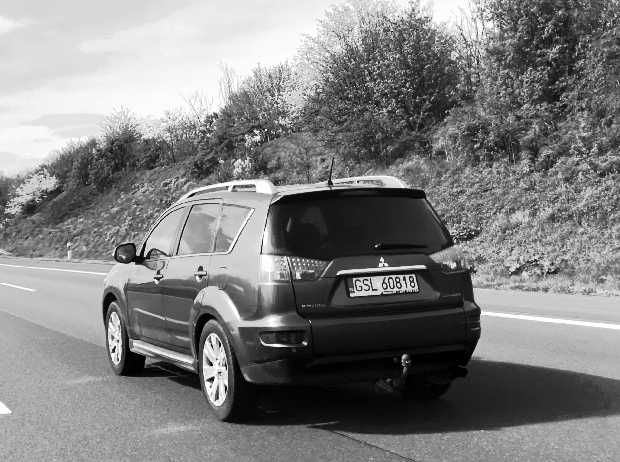

In [834]:
from twm_proj.implementation import initial_filter

importlib.reload(initial_filter)

filtered = initial_filter.InitialFilter().filter(image)
show(filtered)

## Edge filter

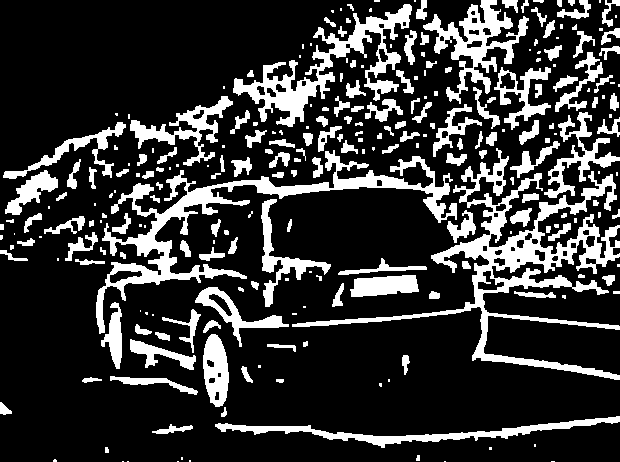

In [835]:
from twm_proj.implementation import edge_filter
importlib.reload(edge_filter)

edges = edge_filter.EdgeFilter().filter(filtered)
show(edges)

## Contour detector

contours count: 310
example contour:
 [[1379 1441]
 [1379 1443]
 [1384 1443]
 [1384 1441]]


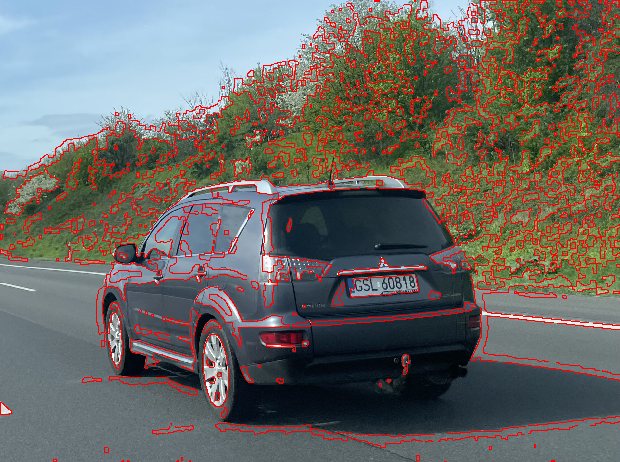

In [836]:
from twm_proj.implementation.contour_detector import ContourDetector

contours = [*ContourDetector().detect(edges)]
print("contours count:", len(contours))
print("example contour:\n", contours[0])
show_contours(image, contours)

## Rectangle detection

rects count: 23
example rect:
 [[ 668 1334]
 [1195 1399]
 [1574 1372]
 [1926 1300]]


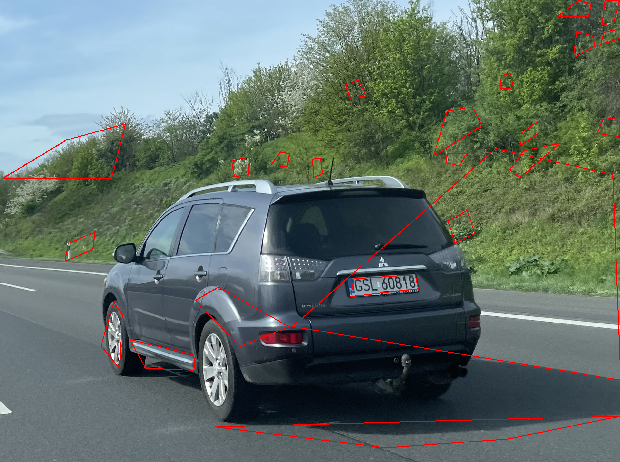

In [837]:
from twm_proj.implementation import rect_detector

importlib.reload(rect_detector)

rects = [rect_detector.RectDetector().detect(contour) for contour in contours]
rects = [rect for rect in rects if rect is not None]
print("rects count:", len(rects))
print("example rect:\n", rects[0] if rects else None)
show_contours(image, rects)

## Rectangle transforming

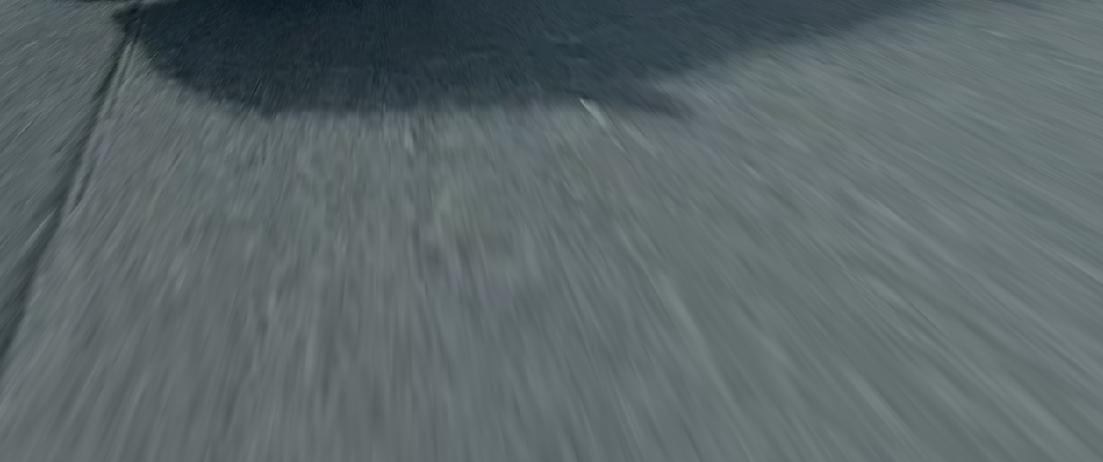

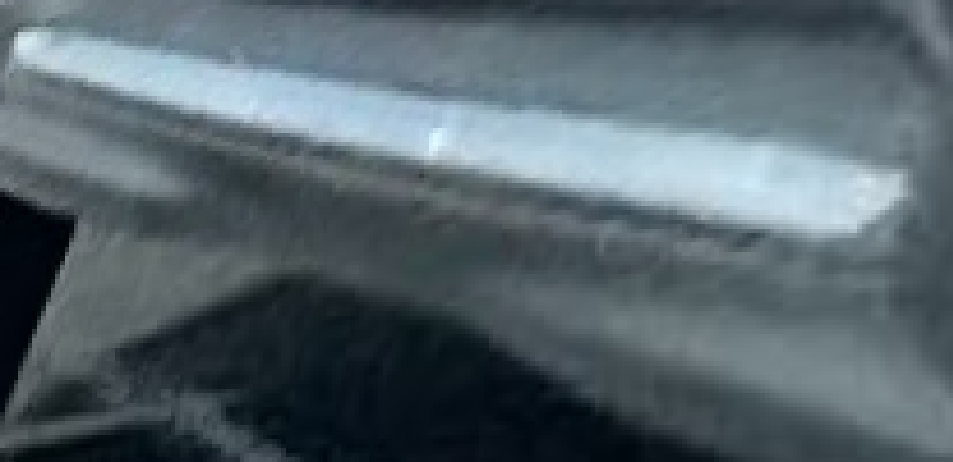

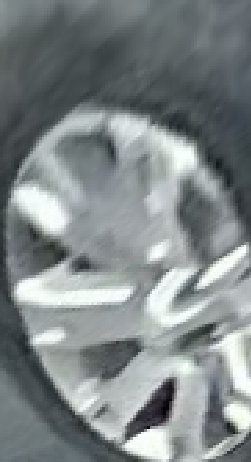

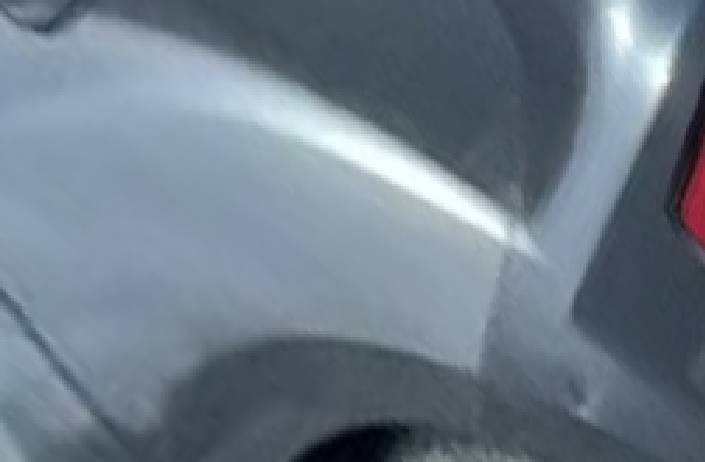

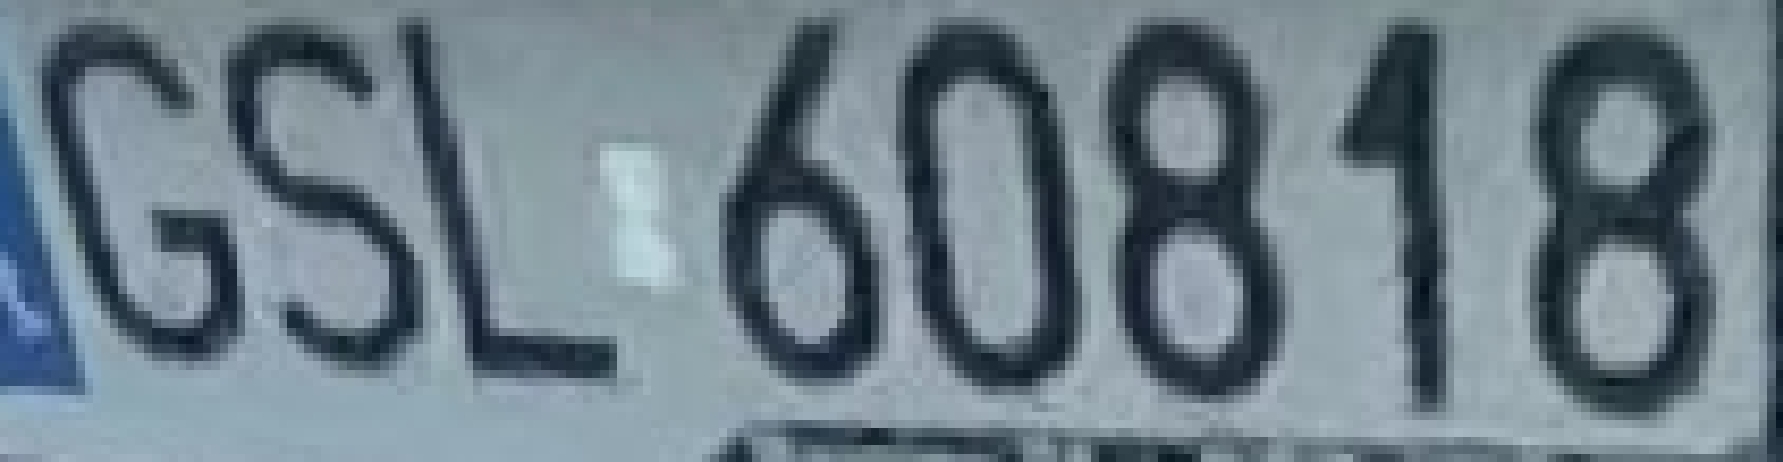

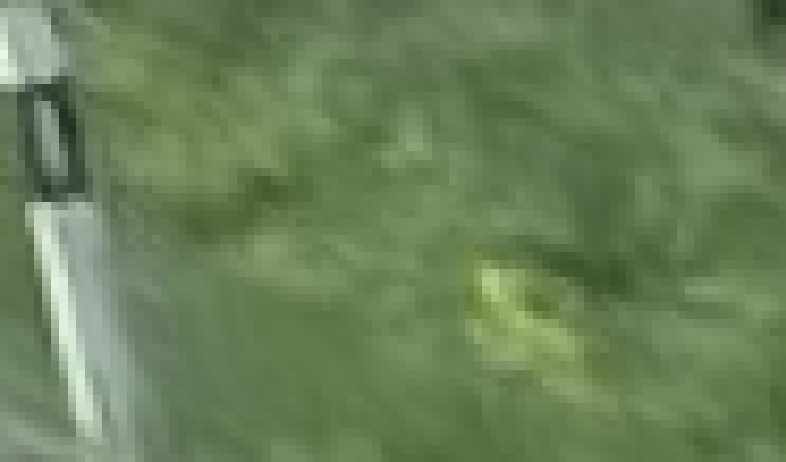

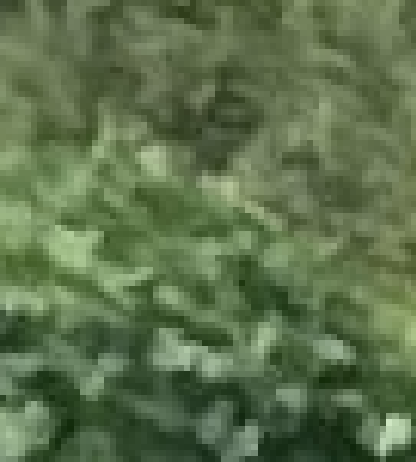

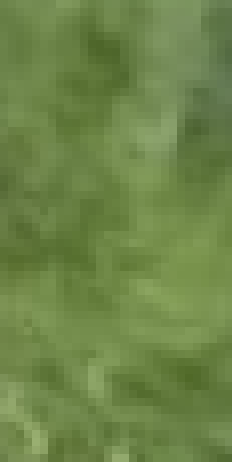

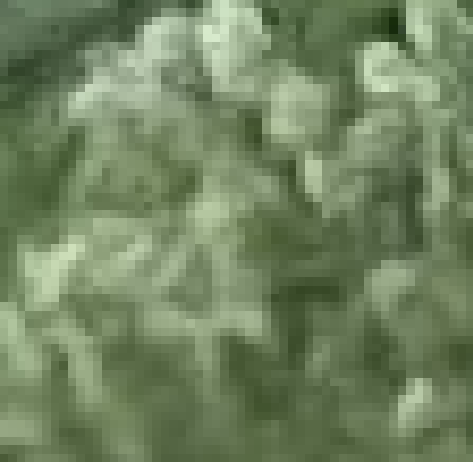

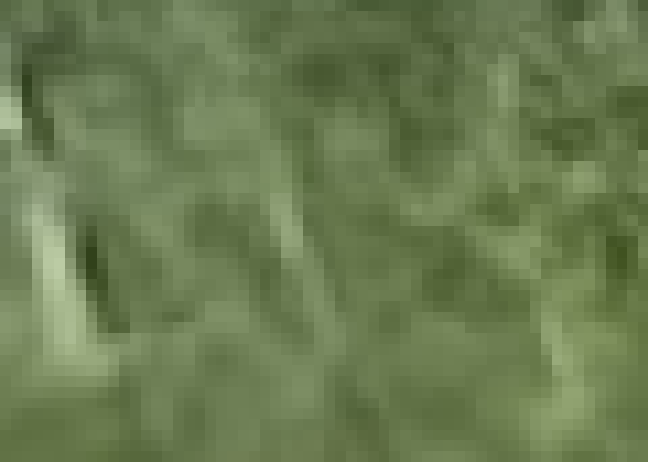

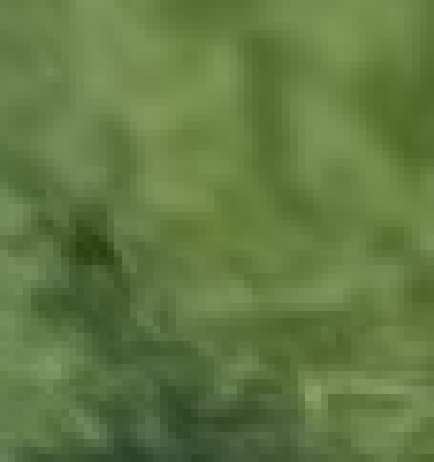

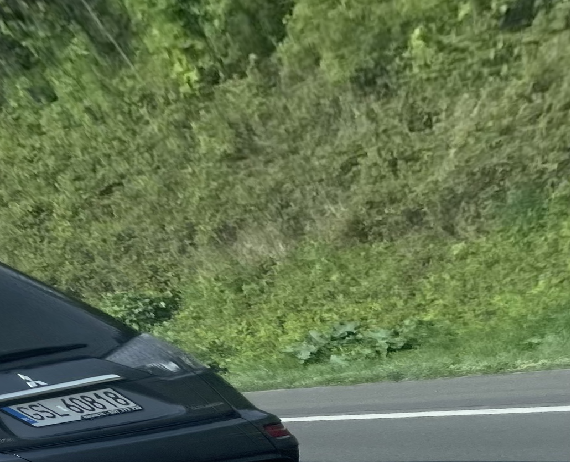

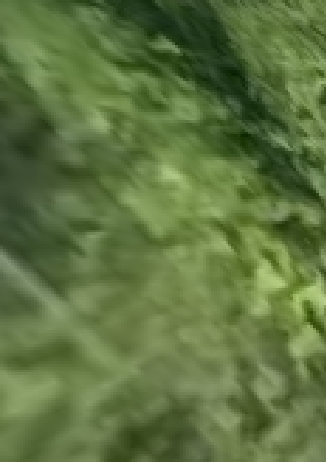

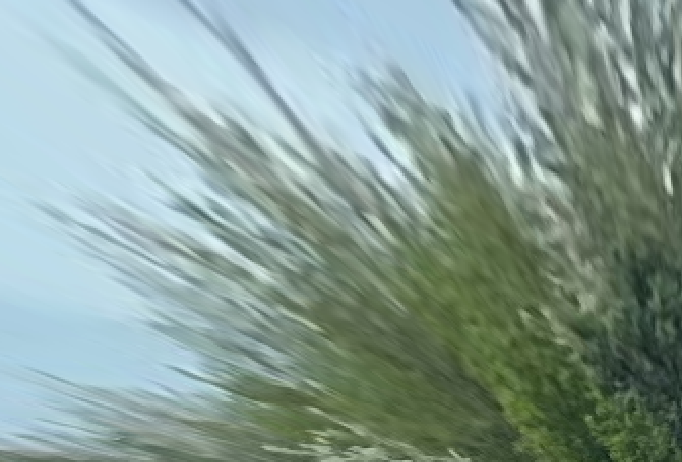

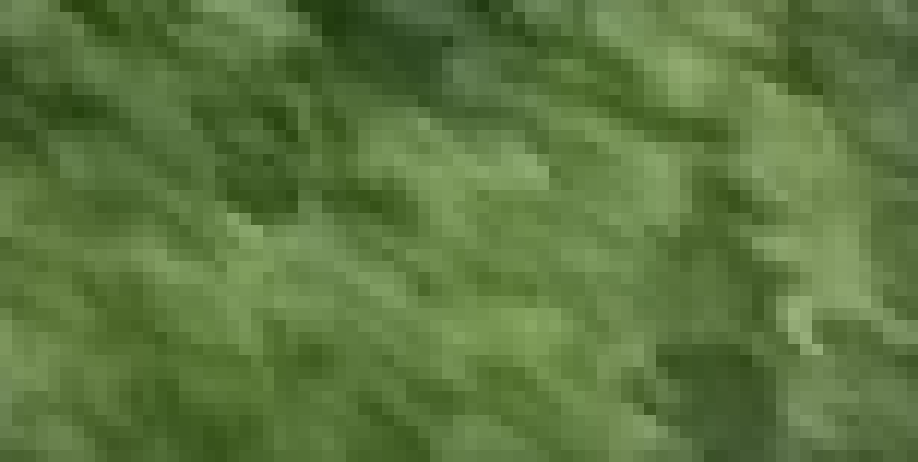

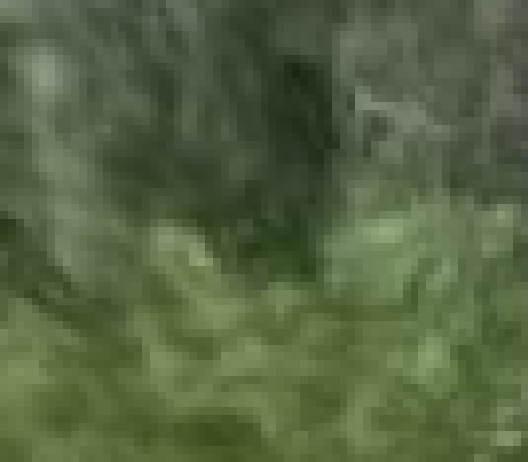

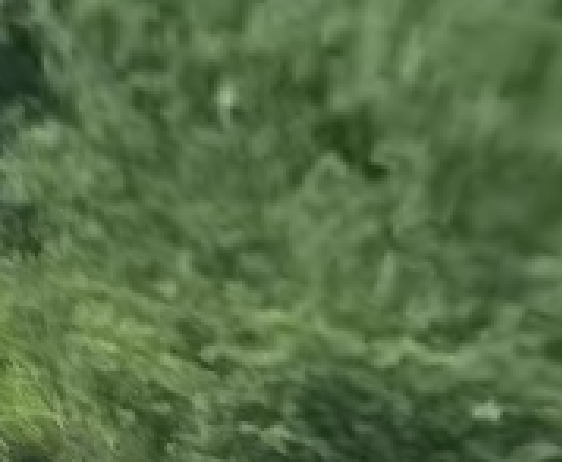

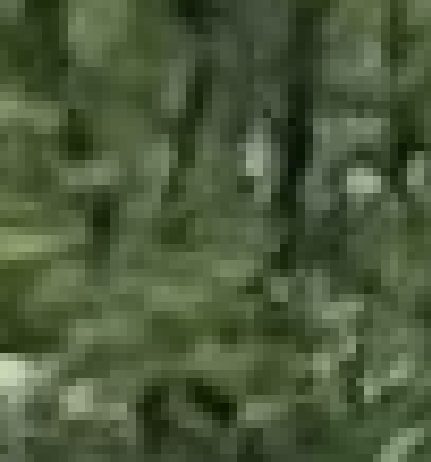

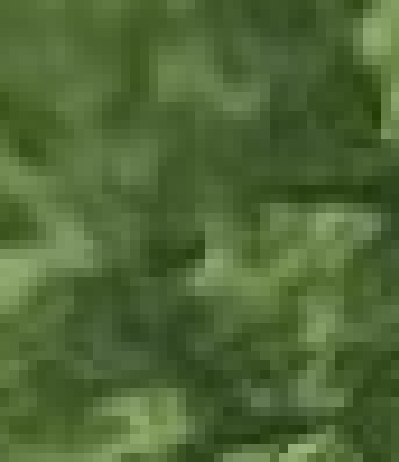

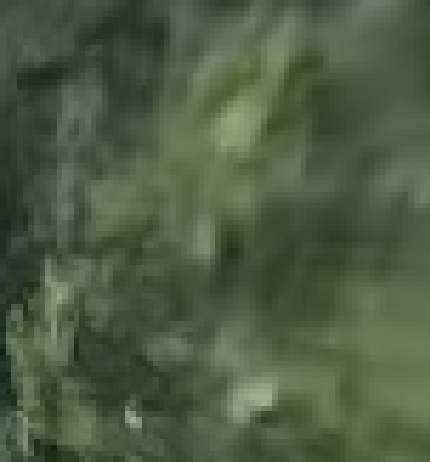

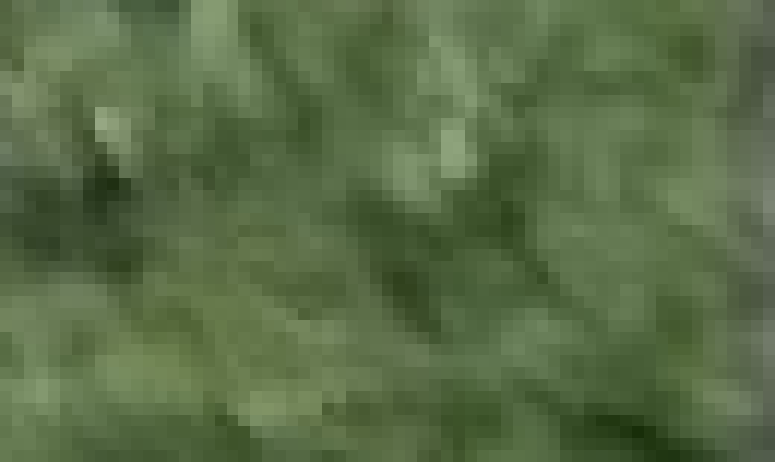

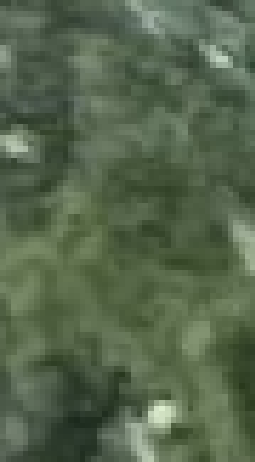

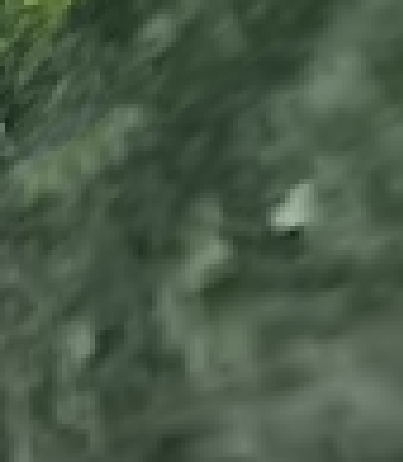

In [838]:
from twm_proj.implementation.rect_transformer import RectTransformer

rect_images = [RectTransformer().transform(image, rect) for rect in rects]
for rect_image in rect_images:
    show(rect_image)

## Rectangle classification

In [839]:
from twm_proj.implementation.rect_classifier import RectClassifier
from twm_proj.interface.rect_classifier import RectangleType

rect_classes = [RectClassifier().classify_with_differences(img) for img in rect_images]
display([(rect_class.name, differences) for rect_class, differences in rect_classes])

plates = [
    rect
    for rect, cls in zip(rect_images, rect_classes)
    if cls != RectangleType.NOT_PLATE
]

[('MINI_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.47963715529753265,
   <RectangleType.TWO_ROW_PLATE: 2>: 0.6654005567584288,
   <RectangleType.MINI_PLATE: 3>: 0.14098831985624433}),
 ('NOT_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.5506854531607007,
   <RectangleType.TWO_ROW_PLATE: 2>: 0.43801330952767414,
   <RectangleType.MINI_PLATE: 3>: 0.25827439886845827}),
 ('NOT_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.88125,
   <RectangleType.TWO_ROW_PLATE: 2>: 0.6199453551912568,
   <RectangleType.MINI_PLATE: 3>: 0.803968253968254}),
 ('TWO_ROW_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.667191844300278,
   <RectangleType.TWO_ROW_PLATE: 2>: 0.06513924550661664,
   <RectangleType.MINI_PLATE: 3>: 0.4506024096385542}),
 ('ONE_ROW_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.15895104895104895,
   <RectangleType.TWO_ROW_PLATE: 2>: 1.6917436661698957,
   <RectangleType.MINI_PLATE: 3>: 0.38839826839826846}),
 ('NOT_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.6293006993006993,


## Pre-OCR processing

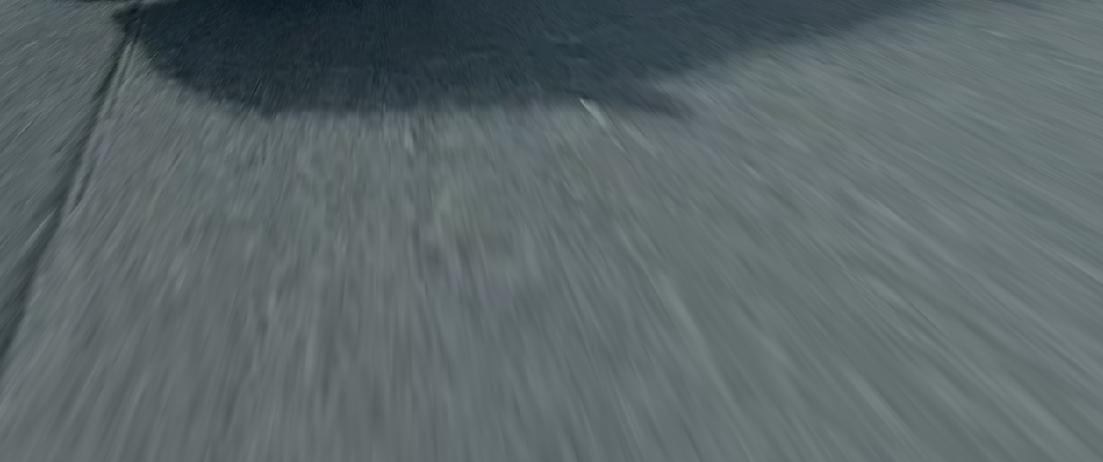

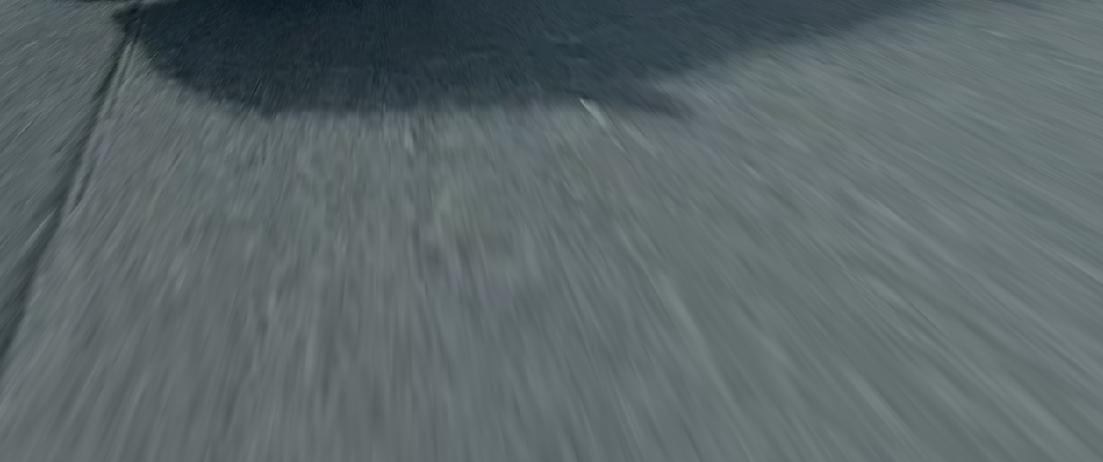

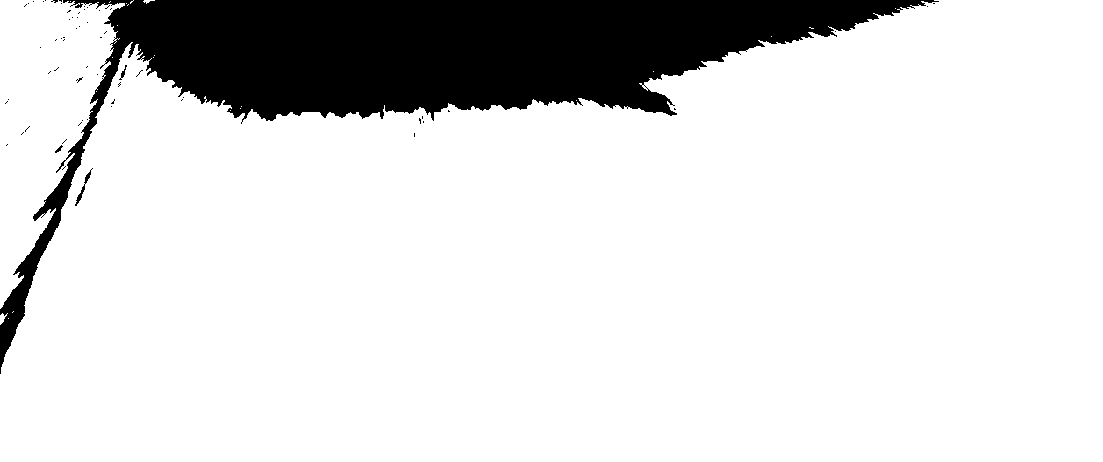

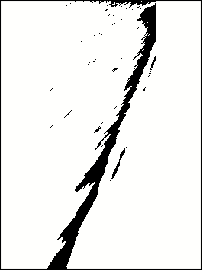

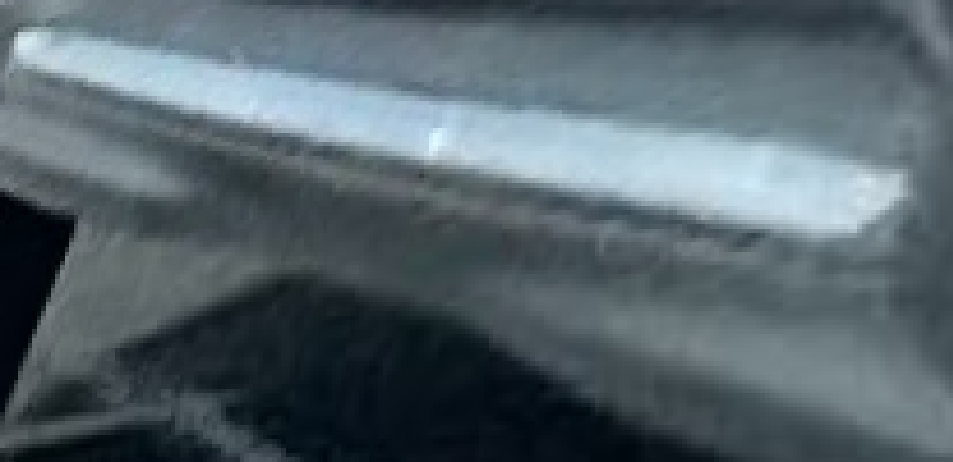

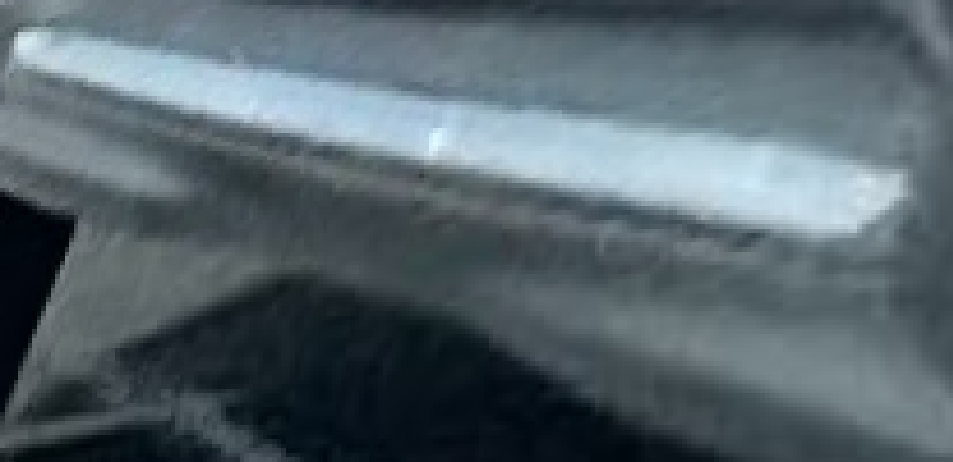

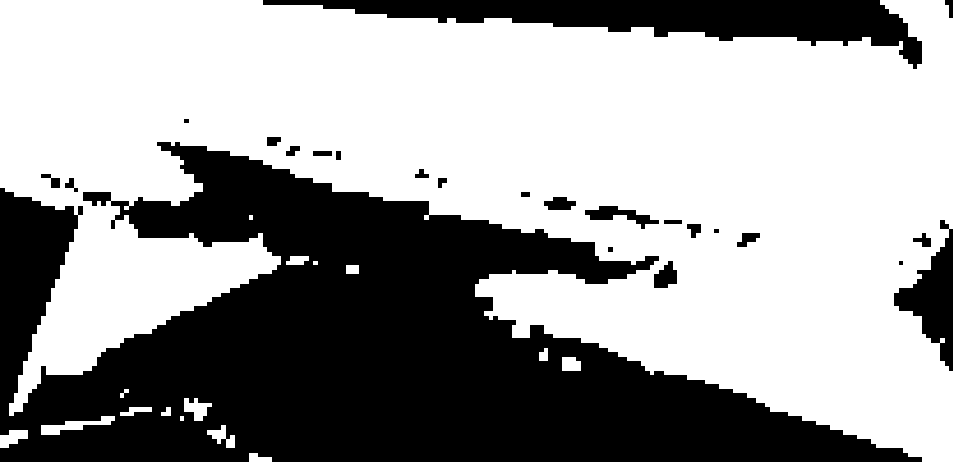

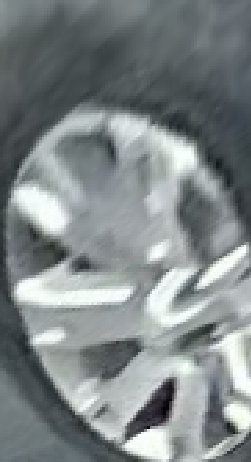

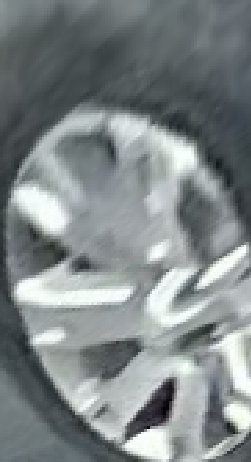

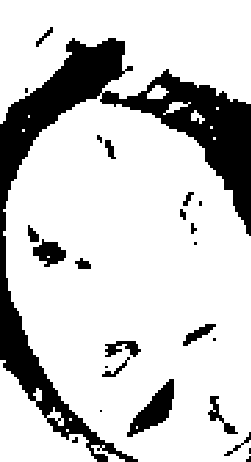

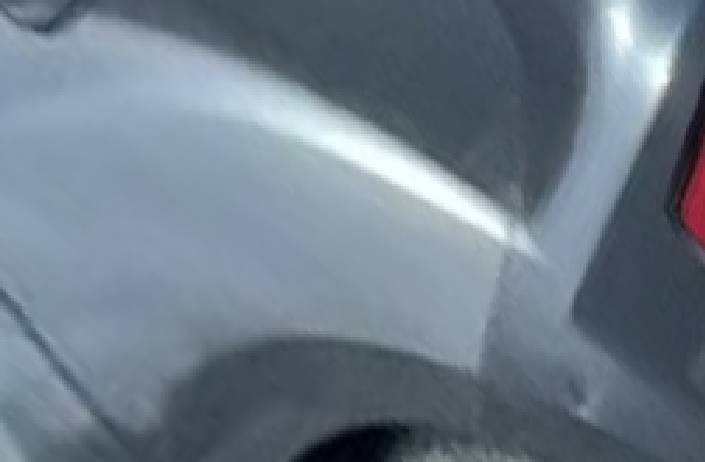

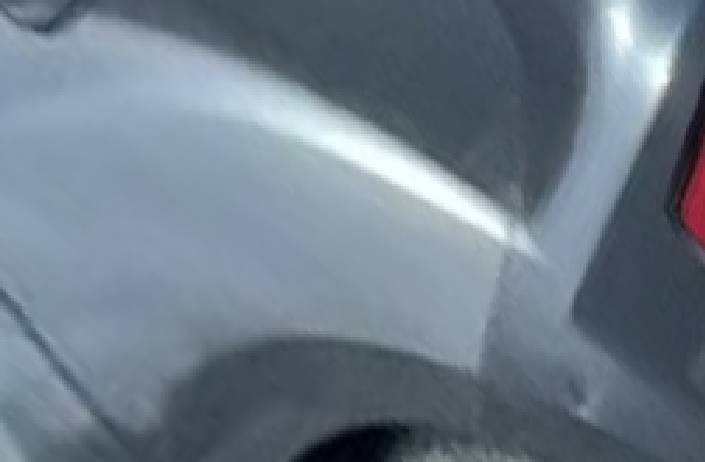

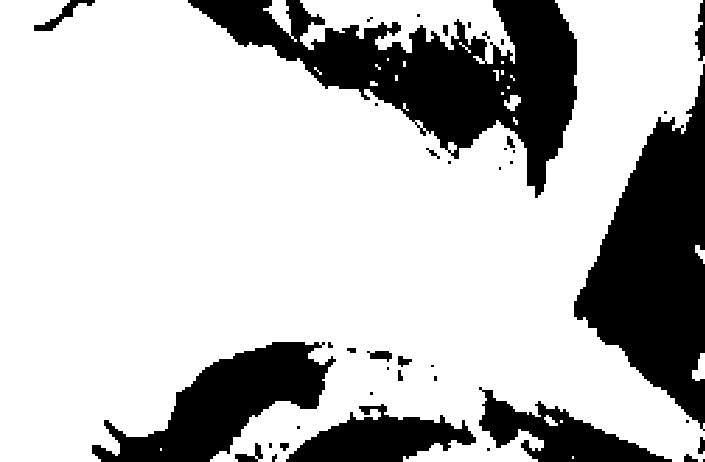

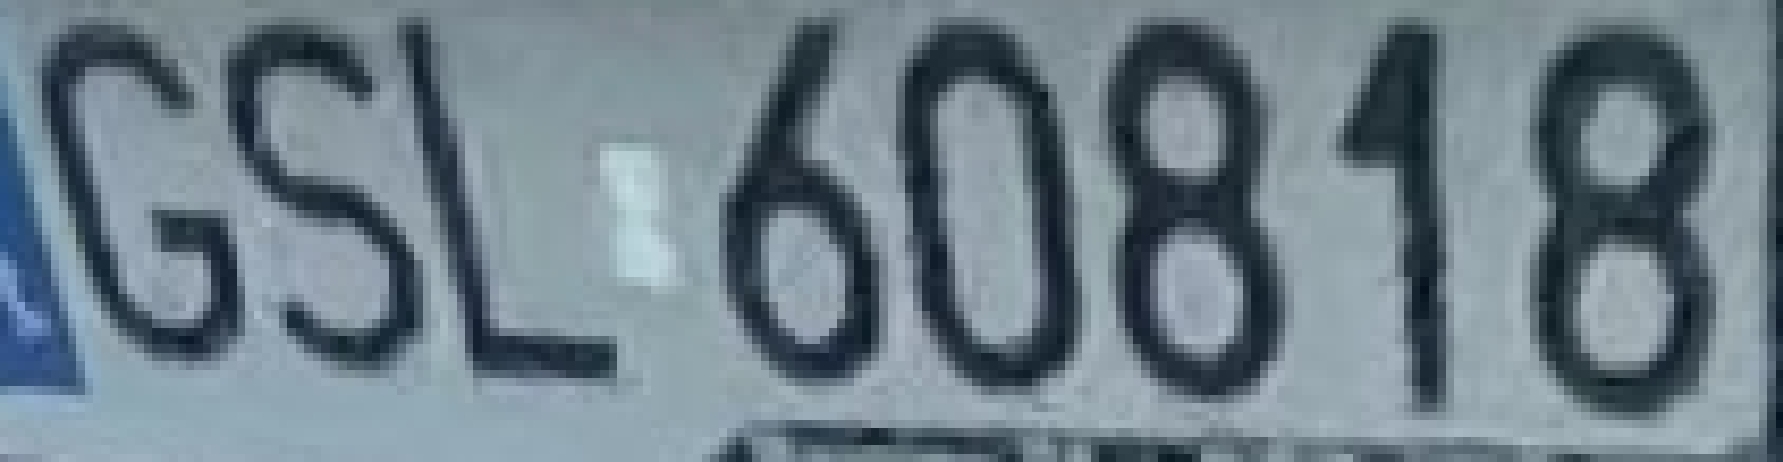

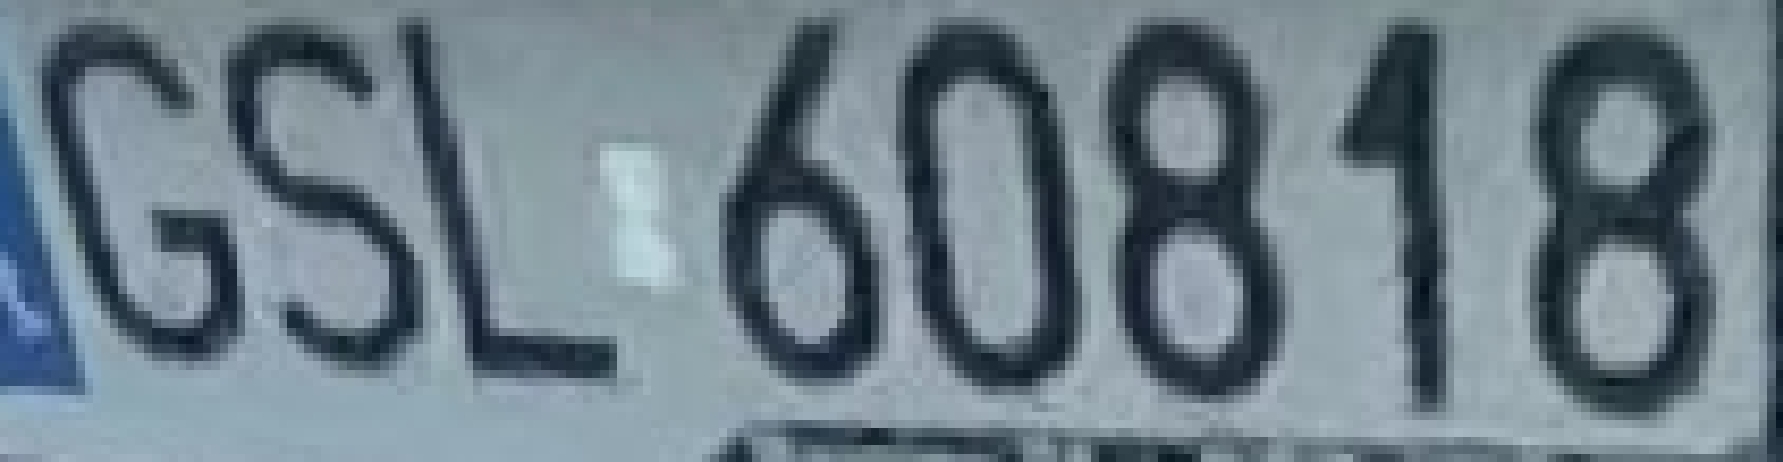

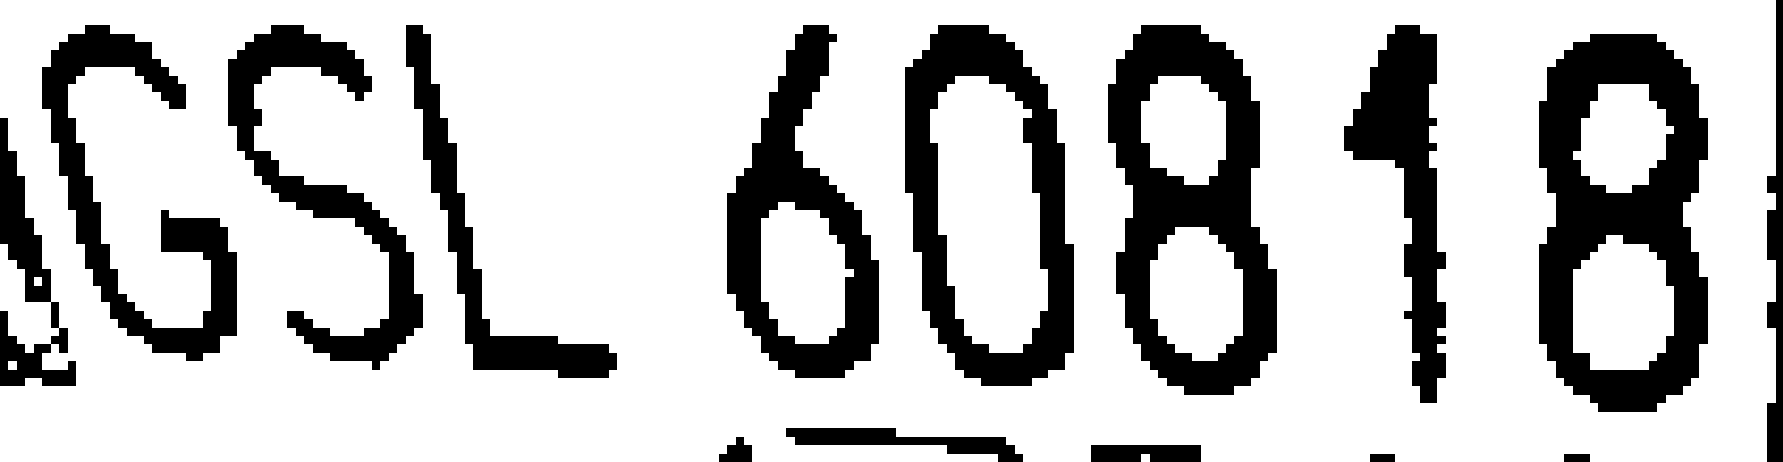

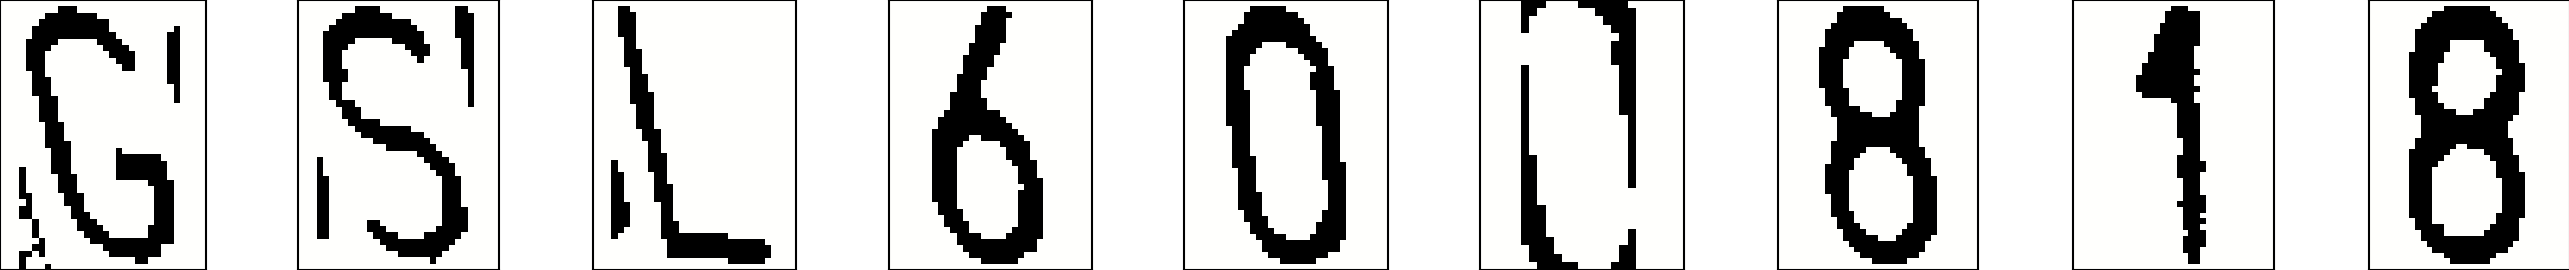

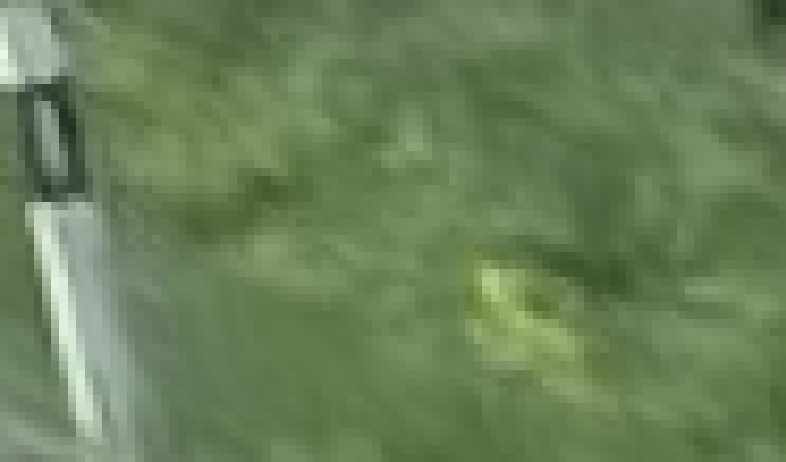

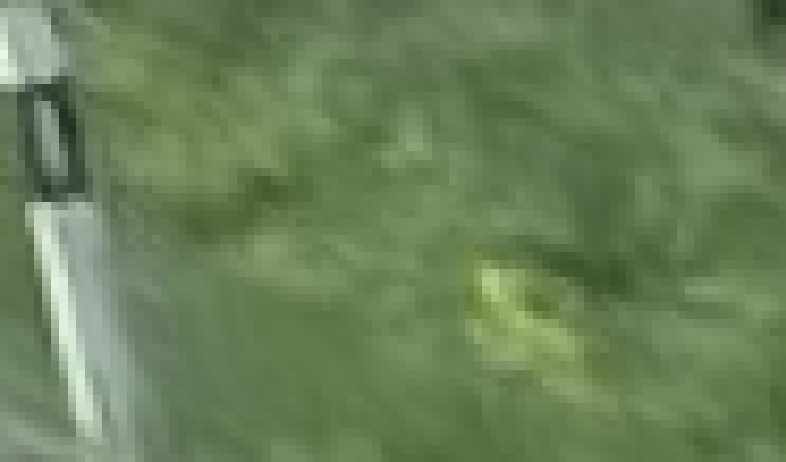

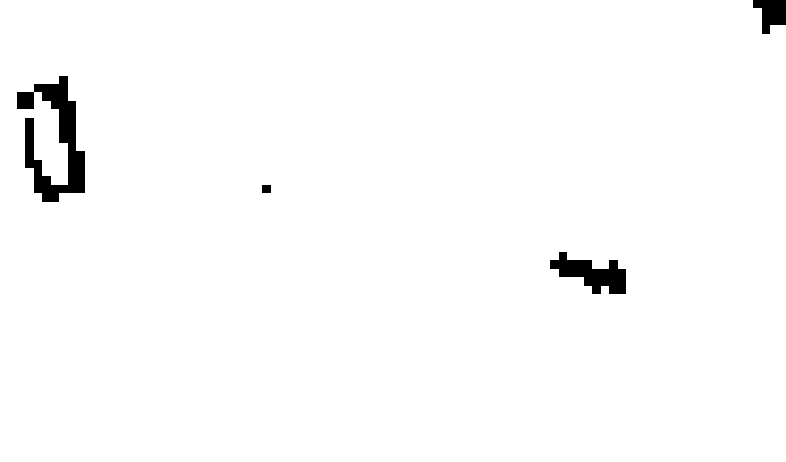

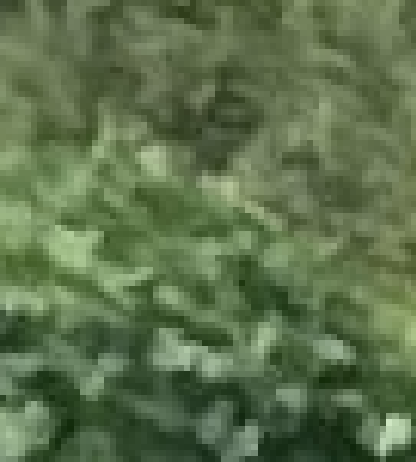

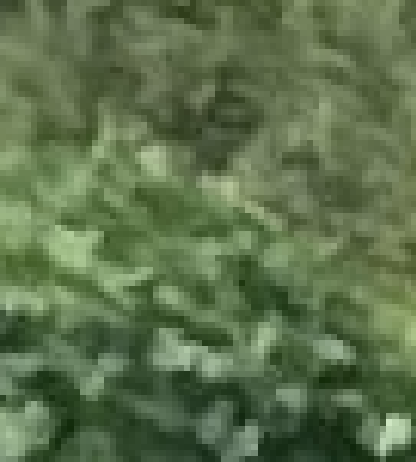

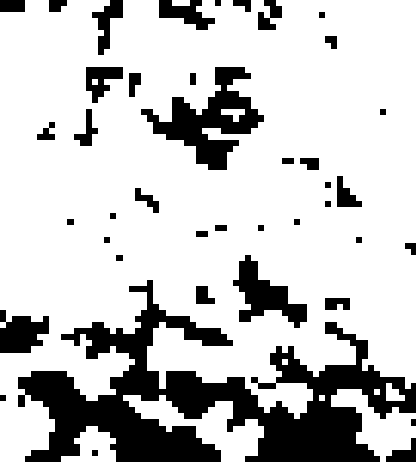

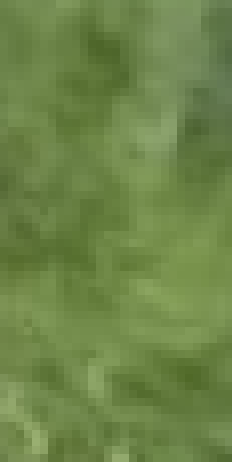

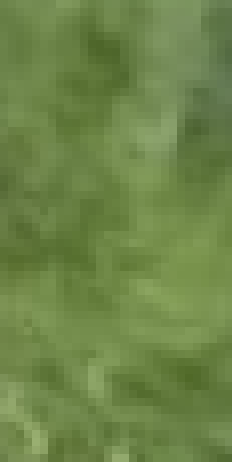

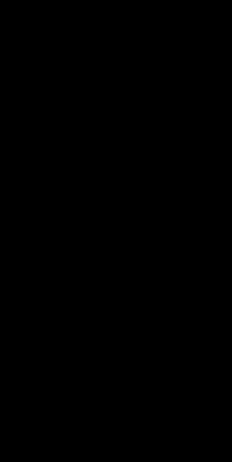

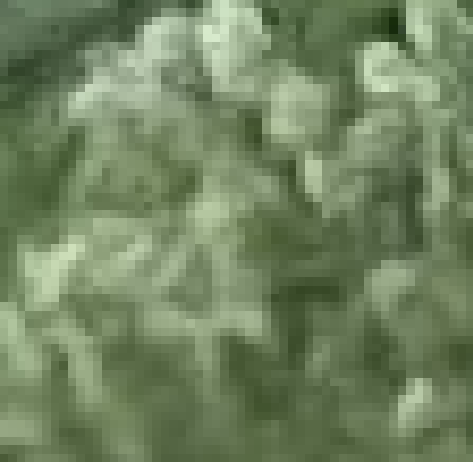

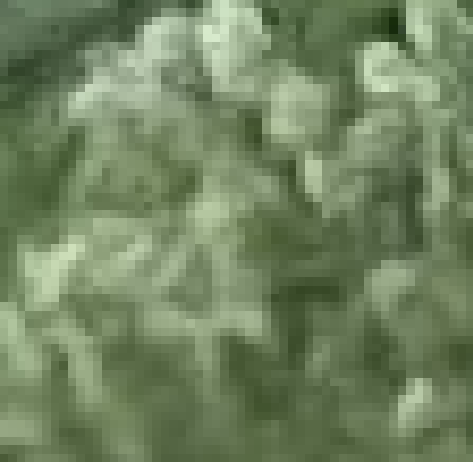

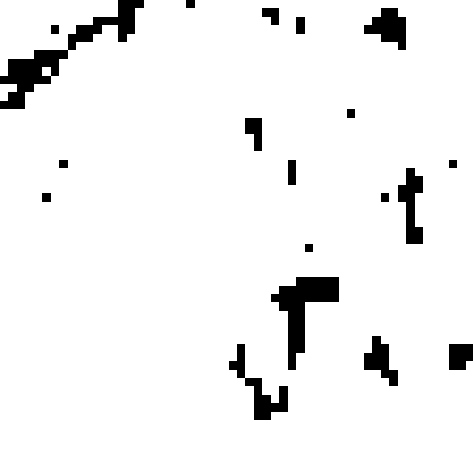

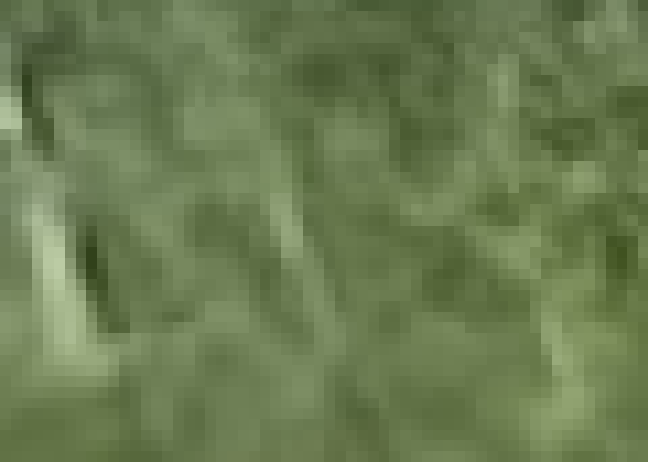

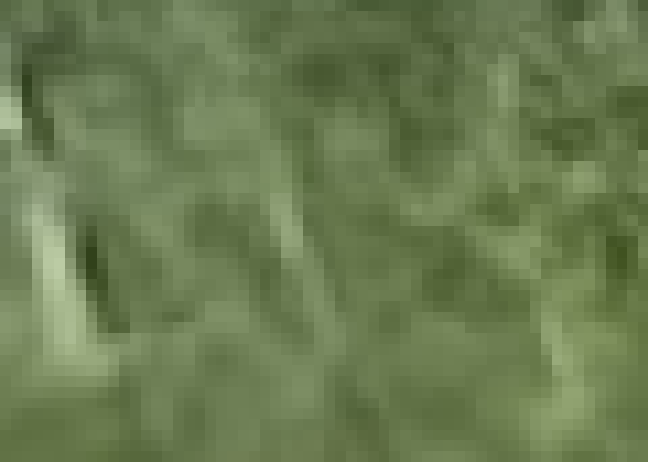

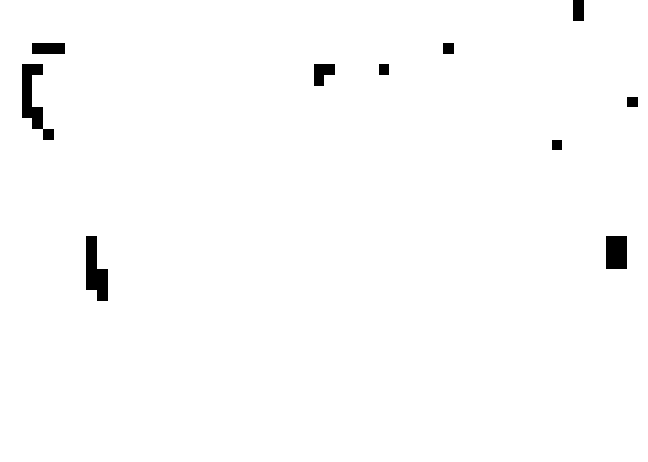

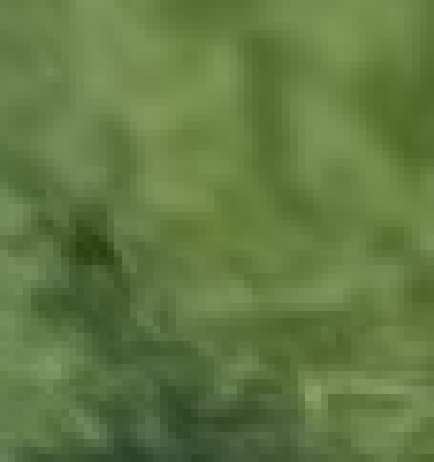

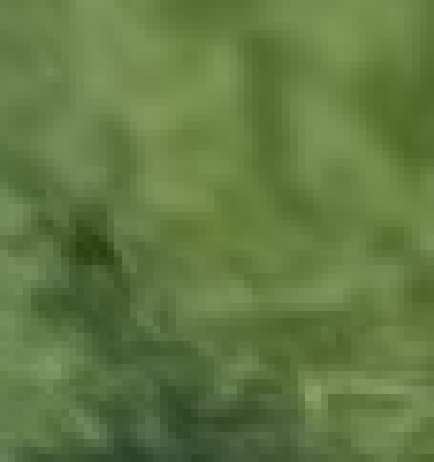

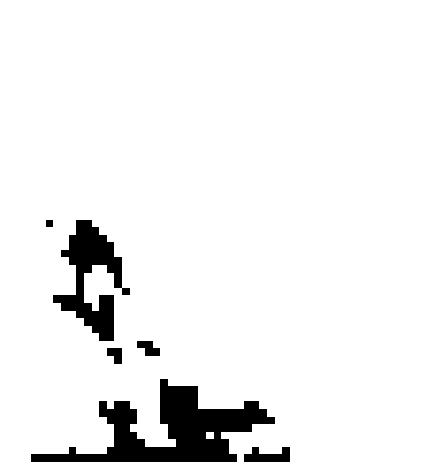

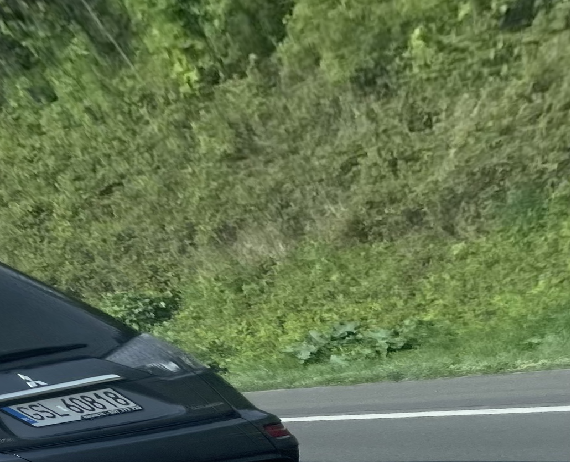

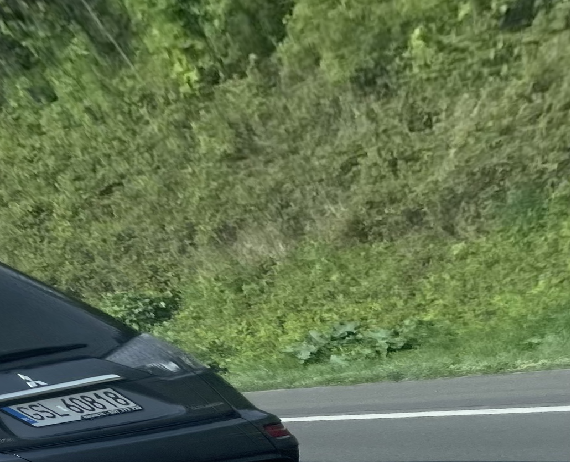

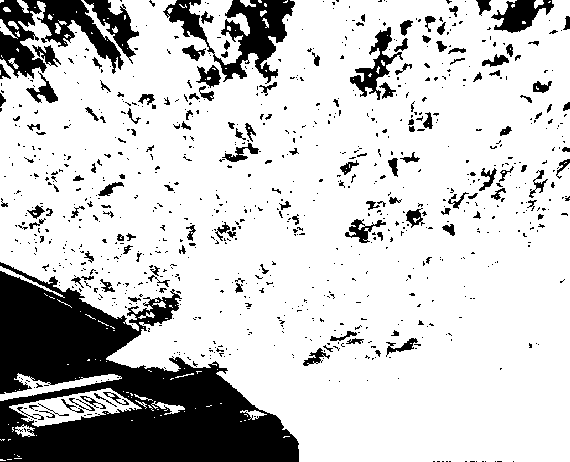

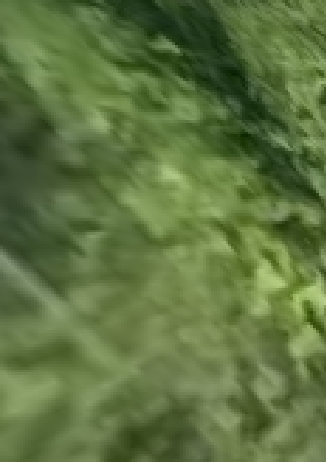

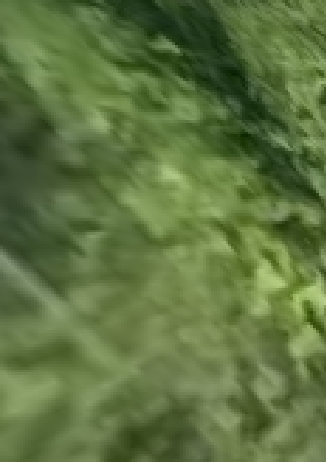

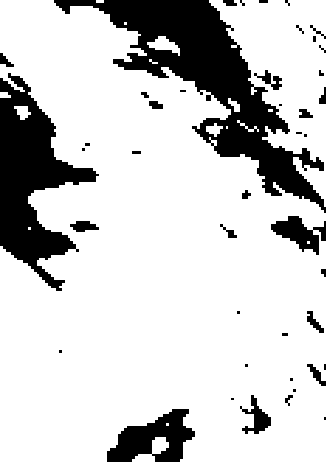

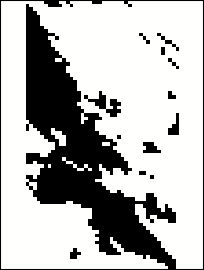

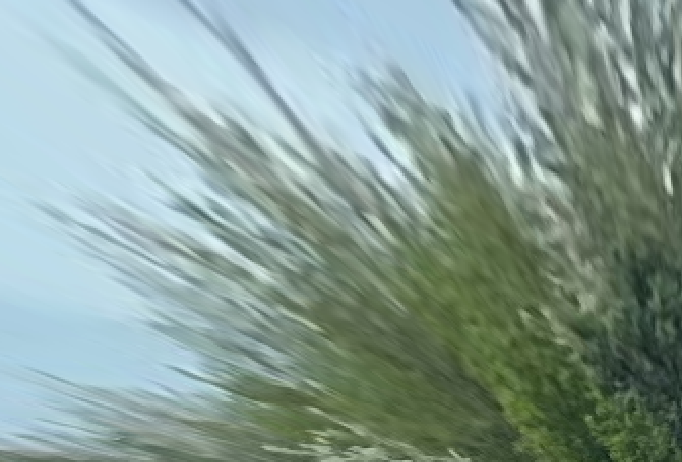

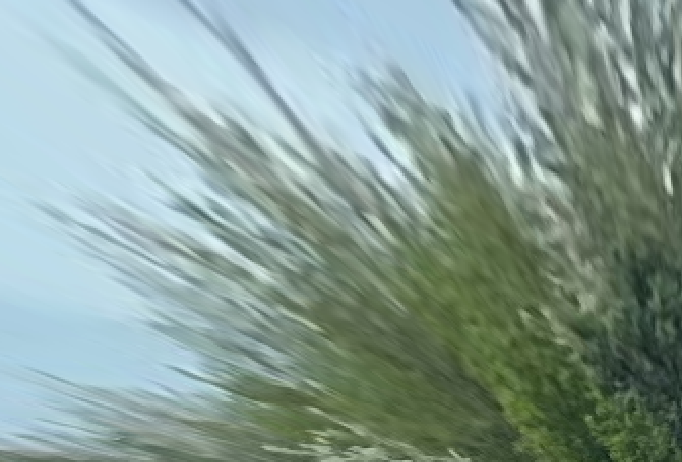

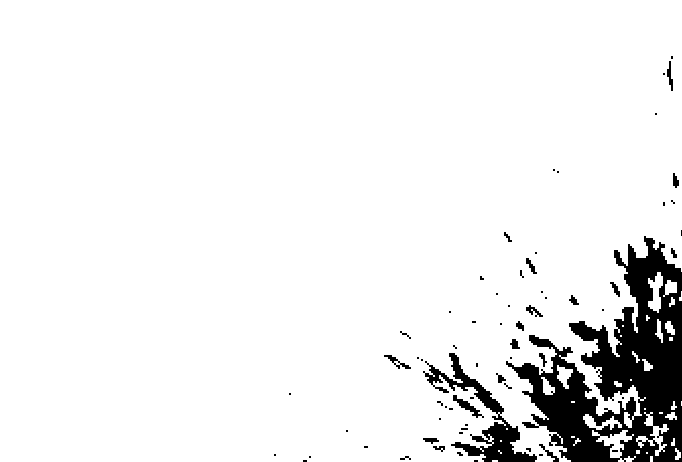

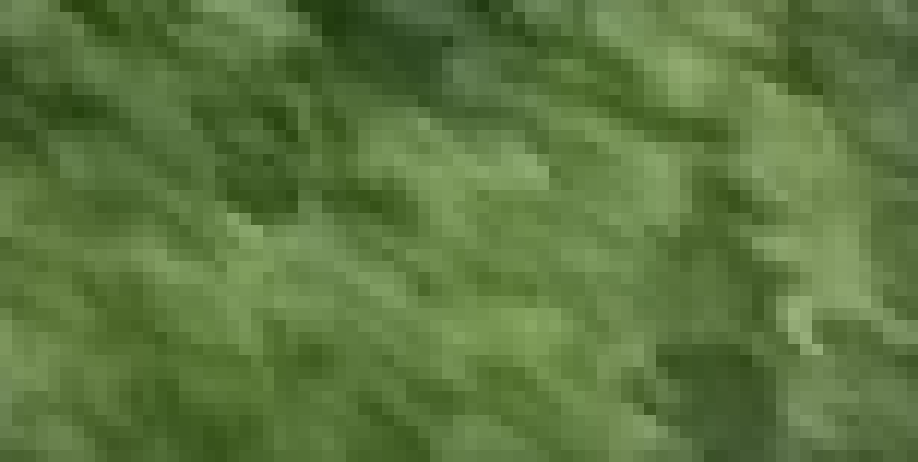

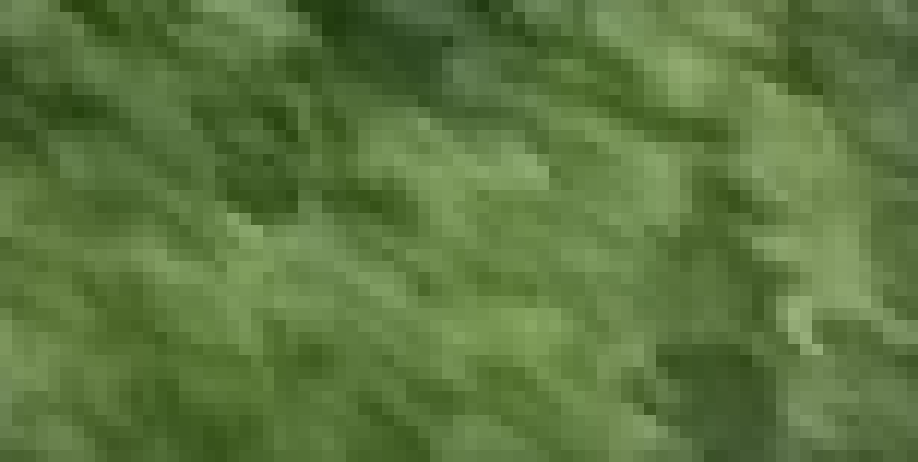

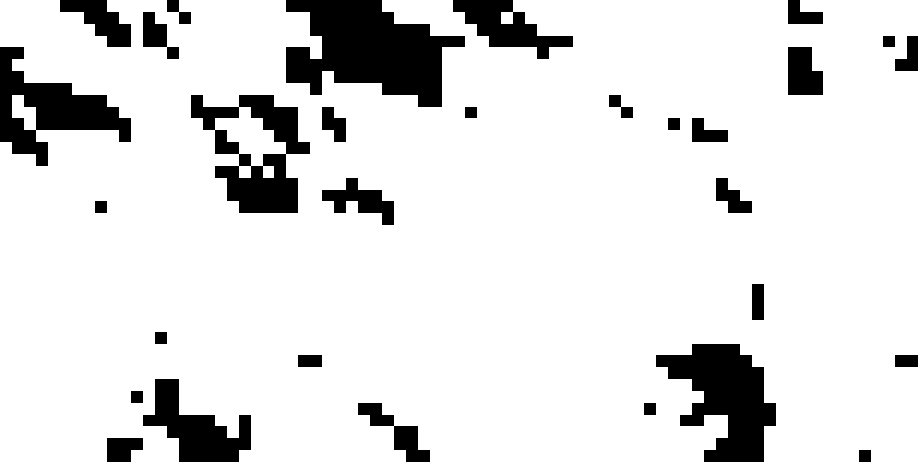

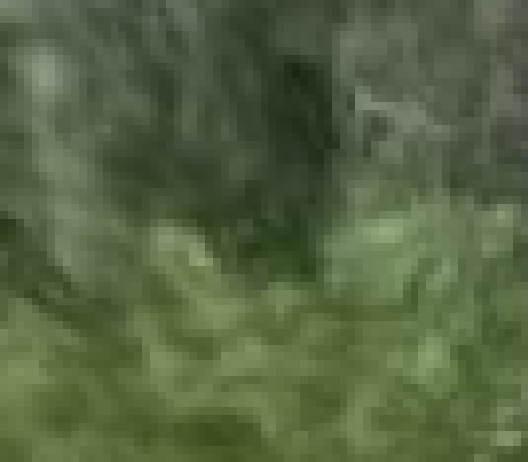

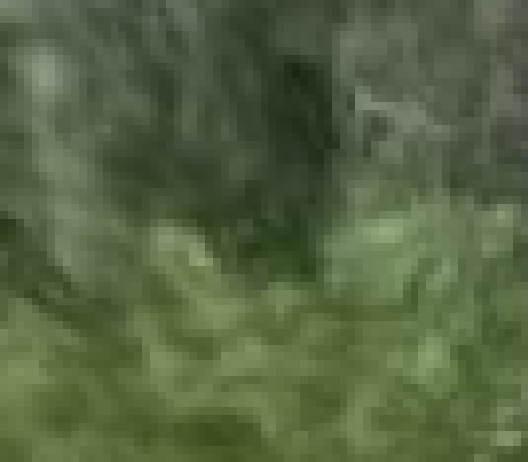

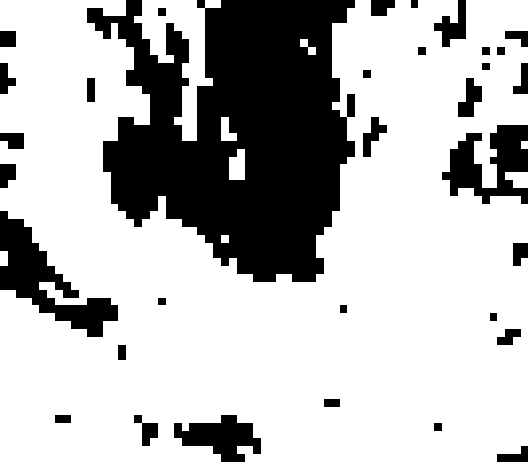

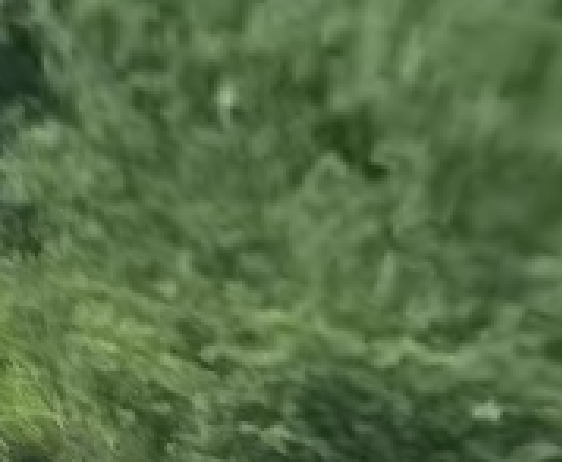

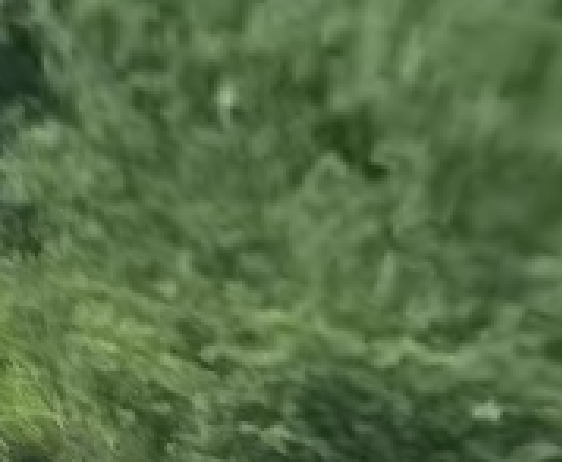

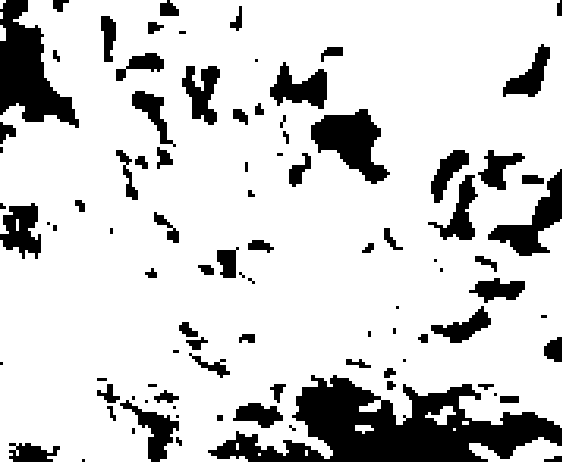

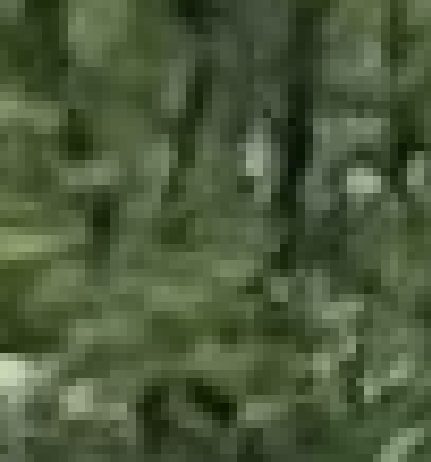

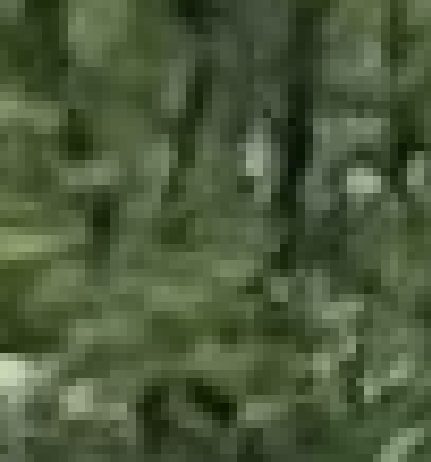

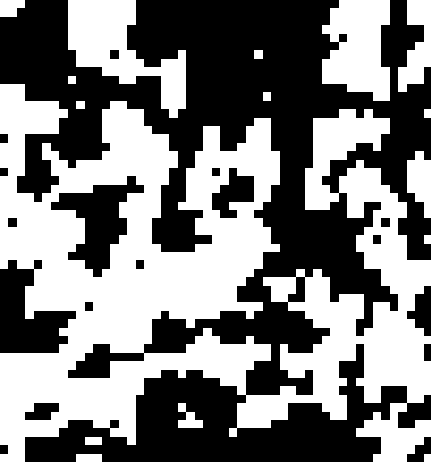

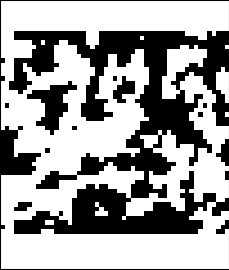

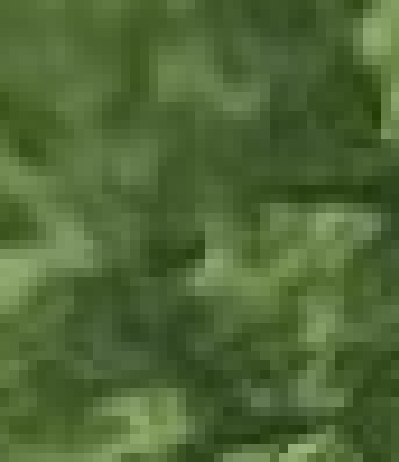

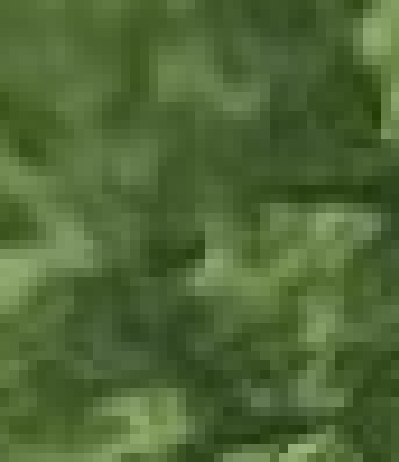

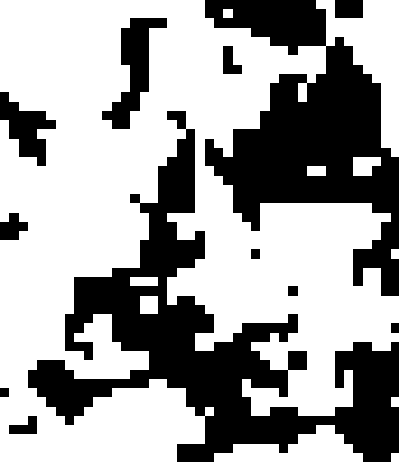

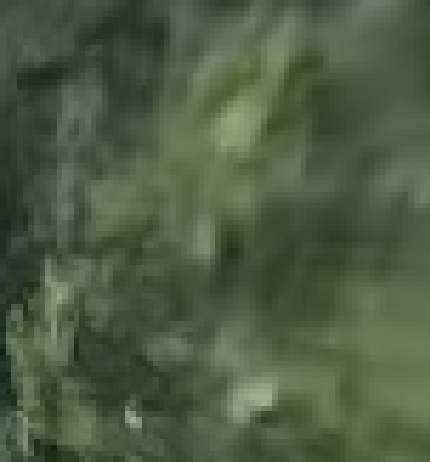

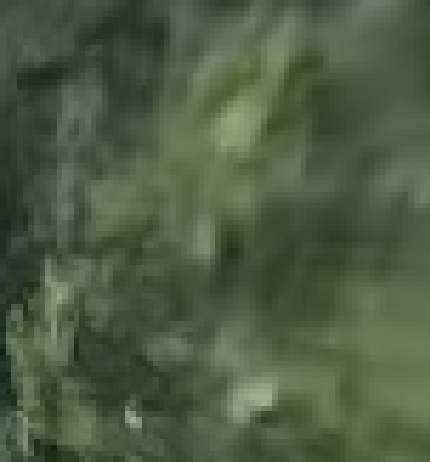

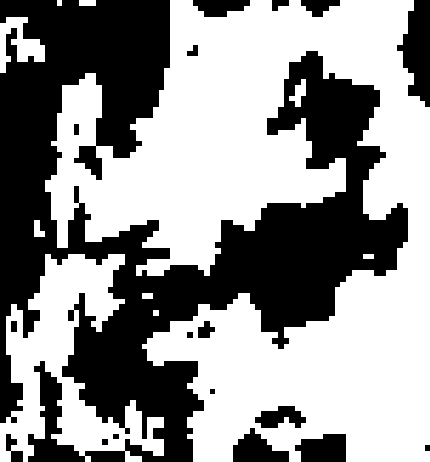

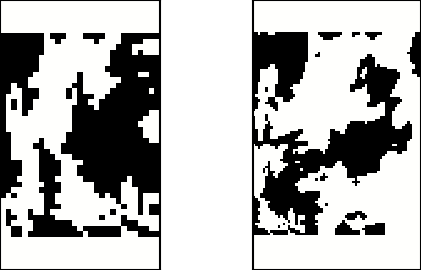

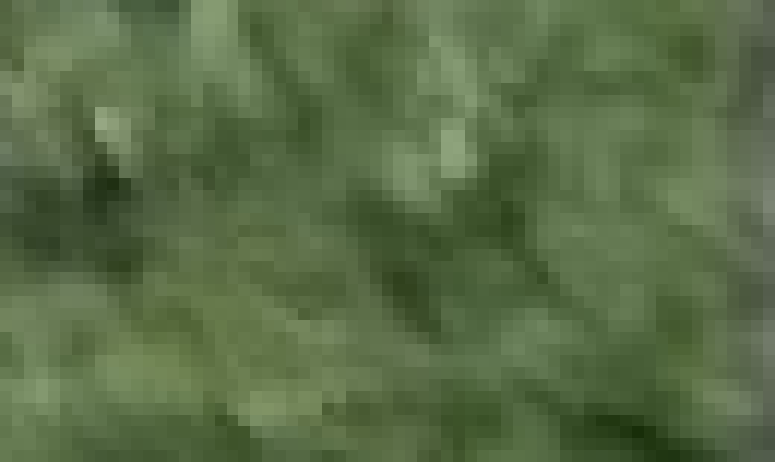

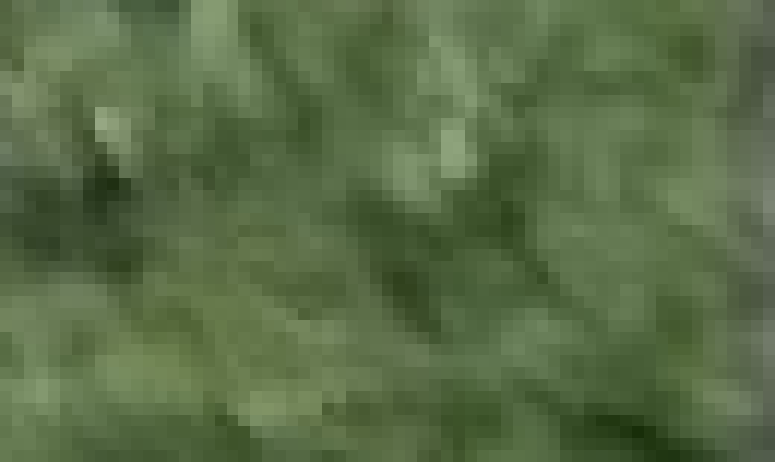

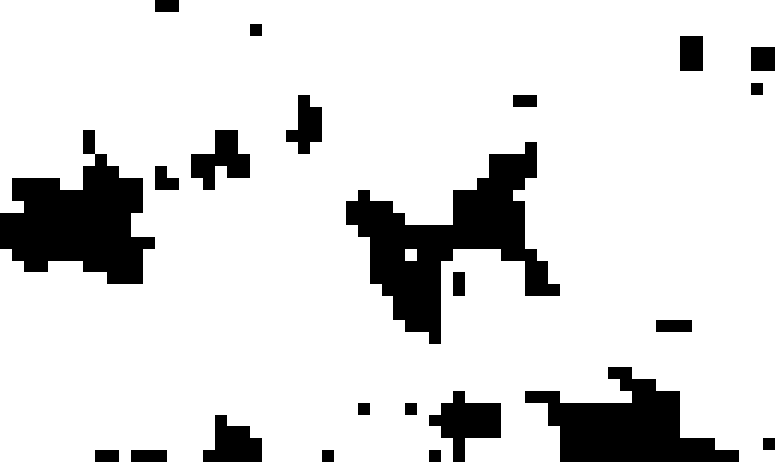

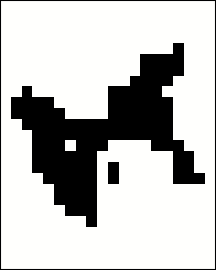

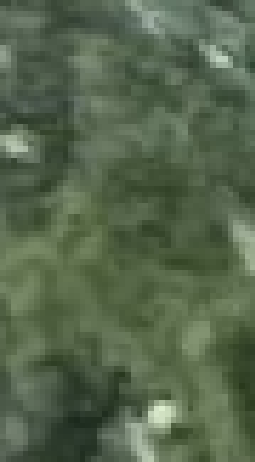

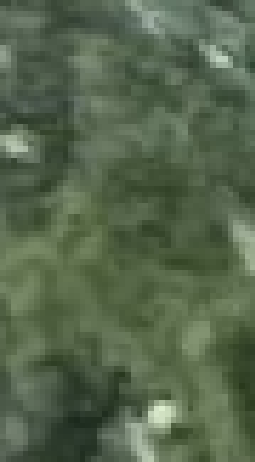

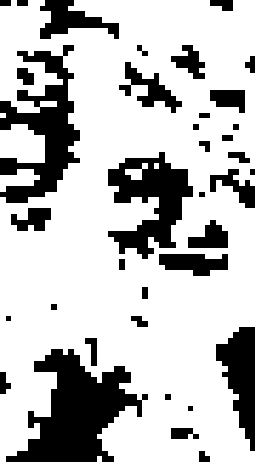

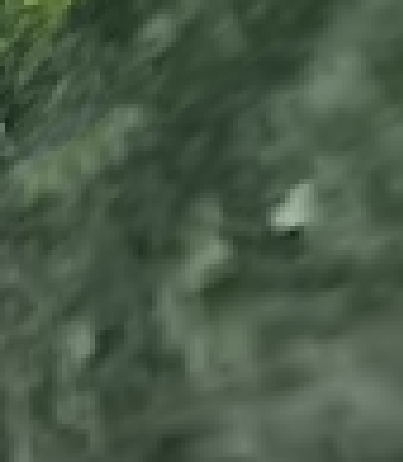

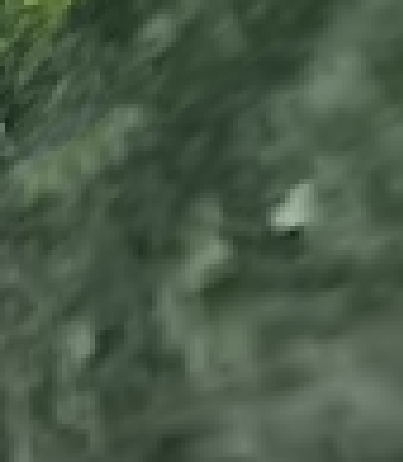

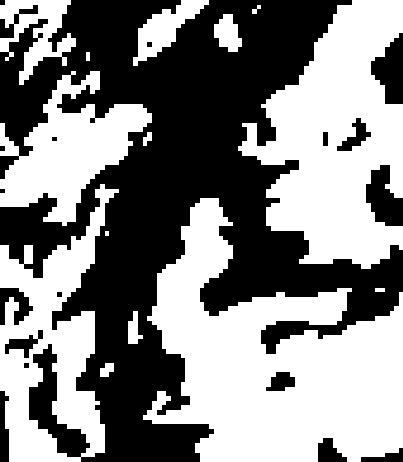

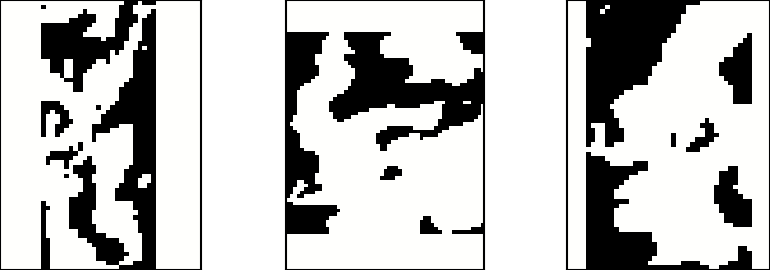

In [840]:
from notebooks.utils import show_collage
from twm_proj.implementation import pre_ocr

importlib.reload(pre_ocr)

plate_letters = []

for plate in plates:
    show(plate)
    plate = pre_ocr.PreOcr().cut(plate)
    show(plate)
    plate = pre_ocr.PreOcr().to_grayscale(plate)
    show(plate)

    letters = [*pre_ocr.PreOcr().get_letters(plate)]
    show_collage(letters, col_wrap=len(letters))

    plate_letters.append(letters)

## OCR

In [841]:
# from twm_proj.implementation.ocr import Ocr


# for letters in plate_letters:
#     scanned_text = Ocr().scan_text(letters)
#     print(scanned_text if scanned_text else None)